In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from matplotlib import ticker

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticCurve
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/2023",
        start_date=date(2022, 9, 5),
        end_date=date(2023, 4, 30),
    ),
    SeasonRange(
        season="2023/2024",
        start_date=date(2023, 9, 4),
        end_date=date(2024, 4, 28),
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=6)

In [5]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 0.5, "sigma": 0.1},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=0.15,
            mu=0.0,
            sigma=0.015,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.1, 0.2],
            mu=[0.0, 0.0],
            sigma=[0.015, 0.015],
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.25, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 45.0, "sigma": 2.0},
        ),
    ],
    covariate_categories=[
        CovariateCategories(covariate="sex", categories=("female", "male")),
        CovariateCategories(covariate="age", categories=("youth", "adult", "senior")),
    ],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.0005,
    name="Test Model",
)
model

In [6]:
model.coordinates().get("season_by_category")

['season_2022_2023_sex_female_age_youth',
 'season_2022_2023_sex_female_age_adult',
 'season_2022_2023_sex_female_age_senior',
 'season_2022_2023_sex_male_age_youth',
 'season_2022_2023_sex_male_age_adult',
 'season_2022_2023_sex_male_age_senior',
 'season_2023_2024_sex_female_age_youth',
 'season_2023_2024_sex_female_age_adult',
 'season_2023_2024_sex_female_age_senior',
 'season_2023_2024_sex_male_age_youth',
 'season_2023_2024_sex_male_age_adult',
 'season_2023_2024_sex_male_age_senior']

{'covariate_age_categories': ['youth', 'adult', 'senior'],
 'covariate_age_categories_limited': ['adult', 'senior'],
 'covariate_names': ['sex', 'age'],
 'covariate_sex_categories': ['female', 'male'],
 'covariate_sex_categories_limited': ['male'],
 'intervention_names': [],
 'parameters': ['m', 'r', 's'],
 'season': ['2022/2023', '2023/2024'],
 'season_2022_2023_dates': ['2022-09-05',
                            '2022-09-06',
                            '2022-09-07',
                            '2022-09-08',
                            '2022-09-09',
                            '2022-09-10',
                            '2022-09-11',
                            '2022-09-12',
                            '2022-09-13',
                            '2022-09-14',
                            '2022-09-15',
                            '2022-09-16',
                            '2022-09-17',
                            '2022-09-18',
                            '2022-09-19',
                       

In [8]:
model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
ERROR: No observations were provided, will not be able to calibrate model only sample from prior.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model with shape [2].
INFO: Added covariate MSex to the model with shape [2].
INFO: Added covariate MAge to the model with shape [2 2].
INFO: Added covariate RSeason to the model with shape [2].
INFO: Added covariate SSeason to the model with shape [2].
INFO: Added season component to parameter m for season 2022/2023 from index (0,) of MSeason.
INFO: Added sex, female covariate component to parameter m for season 2022/2023 from index (0,) of MSex with dimensions ('season',).
INFO: Added summed parameter MSeason20222023SexFemaleAgeYouth to the model with 2 components.
INFO: Added season component to parameter r for season 2022/2023 from index (0,) of RSeason.
INFO: Added summed parameter RSeaso

In [ ]:
model._model  # noqa: SLF001

                                                MSeason ~ Normal(0.5, 0.1)
                                                   MSex ~ RandomWalk(Normal(0.15, 0.015), Normal(0, 0.015), f())
                                         MAgePackedChol ~ _lkjcholeskycov(2, 1, Exponential(f()))
                                                   MAge ~ RandomWalk(MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), f(<multivariate_normal>))
                                                RSeason ~ Normal(-3.25, 0.25)
                                                SSeason ~ Normal(45, 2)
                                                epsilon ~ Exponential(f())
                     Incidence20222023SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex, MSeason, SSeason, RSeason))
                     Incidence20232024SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex

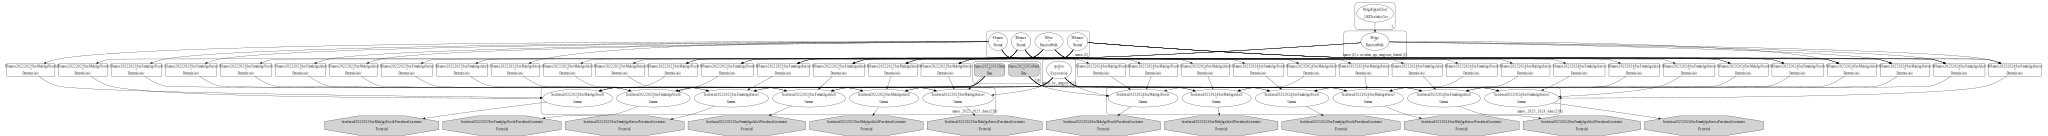

In [ ]:
pm.model_to_graphviz(model._model)  # noqa: SLF001

In [11]:
prior = model.sample_prior()
prior

/Users/twillard/Desktop/GitHub/ACCIDDA/vaxflux/src/vaxflux/uptake.py:705: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive(
Sampling: [Incidence20222023SexFemaleAgeAdult, Incidence20222023SexFemaleAgeSenior, Incidence20222023SexFemaleAgeYouth, Incidence20222023SexMaleAgeAdult, Incidence20222023SexMaleAgeSenior, Incidence20222023SexMaleAgeYouth, Incidence20232024SexFemaleAgeAdult, Incidence20232024SexFemaleAgeSenior, Incidence20232024SexFemaleAgeYouth, Incidence20232024SexMaleAgeAdult, Incidence20232024SexMaleAgeSenior, Incidence20232024SexMaleAgeYouth, MAge, MAgePackedChol, MSeason, MSex, RSeason, SSeason, epsilon]


Inference data with groups:
	> prior
	> constant_data

In [12]:
adult_male_df = (
    prior.prior["Incidence20222023SexMaleAgeAdult"]
    .squeeze()
    .to_dataframe()
    .drop(columns="chain")
)
adult_male_df

Incidence20222023SexMaleAgeAdult
draw season_2022_2023_dates                                  
0    2022-09-05                                  2.172167e-03
     2022-09-06                                  2.102371e-03
     2022-09-07                                  2.373049e-03
     2022-09-08                                  2.317496e-03
     2022-09-09                                  2.665398e-03
...                                                       ...
499  2023-04-26                                  0.000000e+00
     2023-04-27                                  0.000000e+00
     2023-04-28                                  0.000000e+00
     2023-04-29                                  0.000000e+00
     2023-04-30                                 1.884443e-105

[119000 rows x 1 columns]

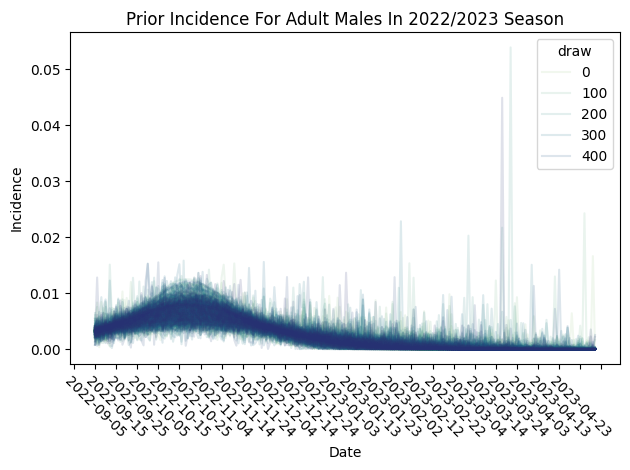

In [13]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Incidence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Prior Incidence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [14]:
adult_male_df = adult_male_df.reset_index().sort_values(
    by=["season_2022_2023_dates", "draw"],
)
adult_male_df["Prevalence20222023SexMaleAgeAdult"] = adult_male_df.groupby("draw")[
    "Incidence20222023SexMaleAgeAdult"
].cumsum()

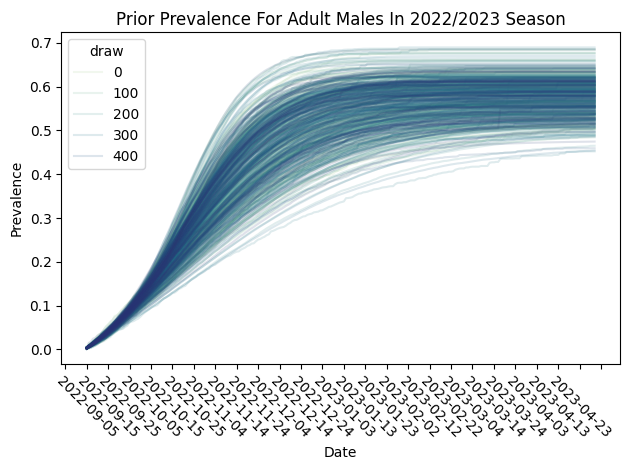

In [15]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Prevalence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Prevalence")
plt.title("Prior Prevalence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [16]:
# Manual generation of a sample data set from one of the prior distribution draws
draw = 10
coords = model.coordinates()
incidence_dfs = []
for label in coords["season_by_category"]:
    split_labels = label.split("_")
    prior_label = "".join(
        w.title() for w in label.replace("season", "incidence").split("_")
    )
    incidence_df = (
        prior.prior[prior_label]
        .sel(chain=0, draw=draw)
        .squeeze()
        .to_dataframe()
        .drop(columns=["chain", "draw"])
    )
    incidence_df[split_labels[0]] = f"{split_labels[1]}/{split_labels[2]}"
    incidence_df[split_labels[3]] = split_labels[4]
    incidence_df[split_labels[5]] = split_labels[6]
    for i in (0, 3, 5):
        incidence_df[split_labels[i]] = incidence_df[split_labels[i]].astype("string")
    incidence_df["date"] = pd.to_datetime(incidence_df.index.to_series())
    incidence_df = incidence_df.reset_index(drop=True)
    incidence_df = incidence_df.rename(columns={prior_label: "incidence"})
    incidence_dfs.append(incidence_df)
incidence_df = pd.concat(incidence_dfs)
incidence_df = incidence_df[["season", "date", "age", "sex", "incidence"]]
incidence_df = incidence_df.sort_values(["season", "date", "age", "sex"])
incidence_df

,season,date,age,sex,incidence
0,2022/2023,2022-09-05,adult,female,2.732415e-03
0,2022/2023,2022-09-05,adult,male,2.335180e-03
0,2022/2023,2022-09-05,senior,female,3.084631e-03
0,2022/2023,2022-09-05,senior,male,3.133844e-03
0,2022/2023,2022-09-05,youth,female,2.908418e-03
...,...,...,...,...,...
237,2023/2024,2024-04-28,adult,male,1.461930e-306
237,2023/2024,2024-04-28,senior,female,0.000000e+00
237,2023/2024,2024-04-28,senior,male,4.772762e-51
237,2023/2024,2024-04-28,youth,female,1.150737e-37


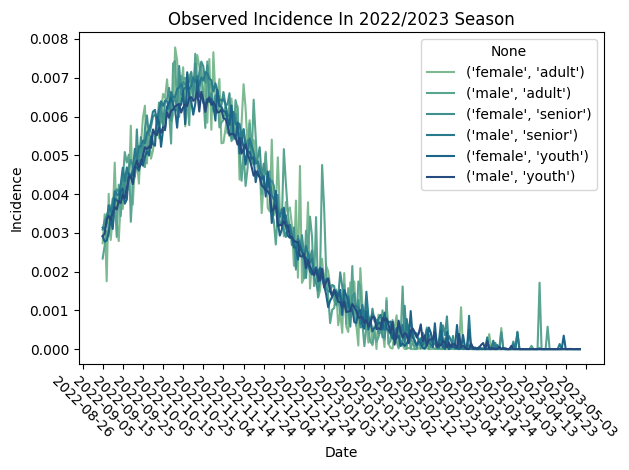

In [17]:
sns.lineplot(
    data=incidence_df[incidence_df["season"] == "2022/2023"],
    x="date",
    y="incidence",
    hue=incidence_df[incidence_df["season"] == "2022/2023"][["sex", "age"]].apply(
        tuple,
        axis=1,
    ),
    palette="crest",
)
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Observed Incidence In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [18]:
incidence_df["prevalence"] = (
    incidence_df.sort_values(["date", "season", "sex", "age"])
    .groupby(["season", "sex", "age"])["incidence"]
    .cumsum()
)
incidence_df

,season,date,age,sex,incidence,prevalence
0,2022/2023,2022-09-05,adult,female,2.732415e-03,0.002732
0,2022/2023,2022-09-05,adult,male,2.335180e-03,0.003085
0,2022/2023,2022-09-05,senior,female,3.084631e-03,0.002908
0,2022/2023,2022-09-05,senior,male,3.133844e-03,0.002335
0,2022/2023,2022-09-05,youth,female,2.908418e-03,0.003134
...,...,...,...,...,...,...
237,2023/2024,2024-04-28,adult,male,1.461930e-306,0.619059
237,2023/2024,2024-04-28,senior,female,0.000000e+00,0.600196
237,2023/2024,2024-04-28,senior,male,4.772762e-51,0.627069
237,2023/2024,2024-04-28,youth,female,1.150737e-37,0.640131


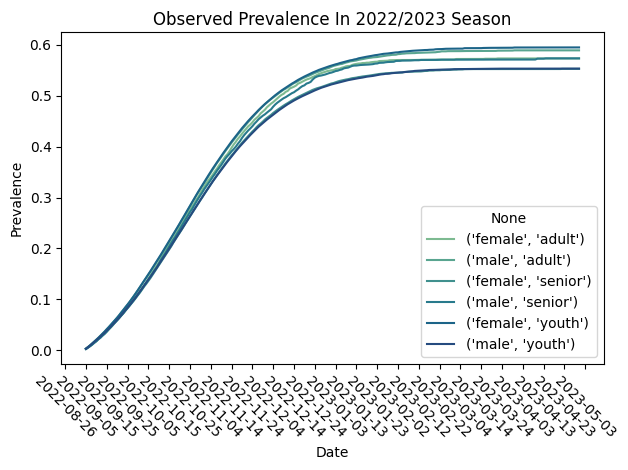

In [19]:
sns.lineplot(
    data=incidence_df[incidence_df["season"] == "2022/2023"],
    x="date",
    y="prevalence",
    hue=incidence_df[incidence_df["season"] == "2022/2023"][["sex", "age"]].apply(
        tuple,
        axis=1,
    ),
    palette="crest",
)
plt.xlabel("Date")
plt.ylabel("Prevalence")
plt.title("Observed Prevalence In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [20]:
observations = incidence_df.copy()
observations = observations.drop(columns=["prevalence"])
observations = (
    observations.groupby(
        ["season", "age", "sex", pd.Grouper(key="date", freq="W-SUN")],
    )["incidence"]
    .sum()
    .reset_index()
)
observations = observations.rename(columns={"date": "end_date", "incidence": "value"})
observations["start_date"] = observations["end_date"] - pd.Timedelta(days=6)
observations["type"] = "incidence"
observations = observations[
    ["season", "start_date", "end_date", "age", "sex", "type", "value"]
]
observations

,season,start_date,end_date,age,sex,type,value
0,2022/2023,2022-09-05,2022-09-11,adult,female,incidence,2.295724e-02
1,2022/2023,2022-09-12,2022-09-18,adult,female,incidence,2.655974e-02
2,2022/2023,2022-09-19,2022-09-25,adult,female,incidence,3.469831e-02
3,2022/2023,2022-09-26,2022-10-02,adult,female,incidence,3.821164e-02
4,2022/2023,2022-10-03,2022-10-09,adult,female,incidence,4.359717e-02
...,...,...,...,...,...,...,...
403,2023/2024,2024-03-25,2024-03-31,youth,male,incidence,3.734192e-04
404,2023/2024,2024-04-01,2024-04-07,youth,male,incidence,5.305981e-04
405,2023/2024,2024-04-08,2024-04-14,youth,male,incidence,3.524628e-06
406,2023/2024,2024-04-15,2024-04-21,youth,male,incidence,9.661910e-06


In [21]:
observations_model = model.add_observations(observations)
observations_model

In [22]:
observations_model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
INFO: Using 68 date ranges for the uptake model.
INFO: Using 408 observational date ranges for the uptake model.
INFO: Using 408 observational date ranges for the uptake model.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model with shape [2].
INFO: Added covariate MSeason to the model with shape [2].
INFO: Added covariate MSex to the model with shape [2].
INFO: Added covariate MSex to the model with shape [2].
INFO: Added covariate MAge to the model with shape [2 2].
INFO: Added covariate MAge to the model with shape [2 2].
INFO: Added covariate RSeason to the model with shape [2].
INFO: Added covariate RSeason to the model with shape [2].
INFO: Added covariate SSeason to the model with shape [2].
INFO: Added covariate S

In [23]:
observations_model.sample(
    tune=5_000,
    draws=500,
    chains=2,
    cores=2,
)

Running window adaptation


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
incidence_posterior_df = observations_model.dataframe()
incidence_posterior_df

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/2023,2022-09-05,female,youth,incidence,0.001576
1,0,0,2022/2023,2022-09-06,female,youth,incidence,0.002876
2,0,0,2022/2023,2022-09-07,female,youth,incidence,0.005983
3,0,0,2022/2023,2022-09-08,female,youth,incidence,0.004903
4,0,0,2022/2023,2022-09-09,female,youth,incidence,0.001735
...,...,...,...,...,...,...,...,...
237995,499,1,2023/2024,2024-04-24,male,senior,incidence,0.000011
237996,499,1,2023/2024,2024-04-25,male,senior,incidence,0.000006
237997,499,1,2023/2024,2024-04-26,male,senior,incidence,0.000002
237998,499,1,2023/2024,2024-04-27,male,senior,incidence,0.000009


In [25]:
incidence_posterior_df[
    (incidence_posterior_df["draw"] == 0)
    & (incidence_posterior_df["chain"] == 0)
    & (incidence_posterior_df["season"] == "2022/2023")
    & (incidence_posterior_df["sex"] == "male")
    & (incidence_posterior_df["age"] == "adult")
].head(10)

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/2023,2022-09-05,male,adult,incidence,0.000689
1,0,0,2022/2023,2022-09-06,male,adult,incidence,0.003614
2,0,0,2022/2023,2022-09-07,male,adult,incidence,0.005239
3,0,0,2022/2023,2022-09-08,male,adult,incidence,0.005289
4,0,0,2022/2023,2022-09-09,male,adult,incidence,0.002307
5,0,0,2022/2023,2022-09-10,male,adult,incidence,0.002750
6,0,0,2022/2023,2022-09-11,male,adult,incidence,0.001790
7,0,0,2022/2023,2022-09-12,male,adult,incidence,0.001130
8,0,0,2022/2023,2022-09-13,male,adult,incidence,0.001966
9,0,0,2022/2023,2022-09-14,male,adult,incidence,0.001605


In [26]:
incidence_posterior_df[
    (incidence_posterior_df["draw"] == 1)
    & (incidence_posterior_df["chain"] == 0)
    & (incidence_posterior_df["season"] == "2022/2023")
    & (incidence_posterior_df["sex"] == "male")
    & (incidence_posterior_df["age"] == "adult")
].head(10)

,draw,chain,season,date,sex,age,type,value
238,1,0,2022/2023,2022-09-05,male,adult,incidence,0.000689
239,1,0,2022/2023,2022-09-06,male,adult,incidence,0.003614
240,1,0,2022/2023,2022-09-07,male,adult,incidence,0.005239
241,1,0,2022/2023,2022-09-08,male,adult,incidence,0.005289
242,1,0,2022/2023,2022-09-09,male,adult,incidence,0.002307
243,1,0,2022/2023,2022-09-10,male,adult,incidence,0.002750
244,1,0,2022/2023,2022-09-11,male,adult,incidence,0.001790
245,1,0,2022/2023,2022-09-12,male,adult,incidence,0.001130
246,1,0,2022/2023,2022-09-13,male,adult,incidence,0.001966
247,1,0,2022/2023,2022-09-14,male,adult,incidence,0.001605


In [27]:
incidence_posterior_df[
    (incidence_posterior_df["draw"] == 0)
    & (incidence_posterior_df["chain"] == 1)
    & (incidence_posterior_df["season"] == "2022/2023")
    & (incidence_posterior_df["sex"] == "male")
    & (incidence_posterior_df["age"] == "adult")
].head(10)

,draw,chain,season,date,sex,age,type,value
119000,0,1,2022/2023,2022-09-05,male,adult,incidence,0.003406
119001,0,1,2022/2023,2022-09-06,male,adult,incidence,0.003870
119002,0,1,2022/2023,2022-09-07,male,adult,incidence,0.003801
119003,0,1,2022/2023,2022-09-08,male,adult,incidence,0.003653
119004,0,1,2022/2023,2022-09-09,male,adult,incidence,0.002165
119005,0,1,2022/2023,2022-09-10,male,adult,incidence,0.002915
119006,0,1,2022/2023,2022-09-11,male,adult,incidence,0.001865
119007,0,1,2022/2023,2022-09-12,male,adult,incidence,0.003877
119008,0,1,2022/2023,2022-09-13,male,adult,incidence,0.005760
119009,0,1,2022/2023,2022-09-14,male,adult,incidence,0.005690


In [28]:
incidence_posterior_df[
    (incidence_posterior_df["draw"] == 3)
    & (incidence_posterior_df["chain"] == 1)
    & (incidence_posterior_df["season"] == "2022/2023")
    & (incidence_posterior_df["sex"] == "male")
    & (incidence_posterior_df["age"] == "adult")
].head(10)

,draw,chain,season,date,sex,age,type,value
119714,3,1,2022/2023,2022-09-05,male,adult,incidence,0.003406
119715,3,1,2022/2023,2022-09-06,male,adult,incidence,0.003870
119716,3,1,2022/2023,2022-09-07,male,adult,incidence,0.003801
119717,3,1,2022/2023,2022-09-08,male,adult,incidence,0.003653
119718,3,1,2022/2023,2022-09-09,male,adult,incidence,0.002165
119719,3,1,2022/2023,2022-09-10,male,adult,incidence,0.002915
119720,3,1,2022/2023,2022-09-11,male,adult,incidence,0.001865
119721,3,1,2022/2023,2022-09-12,male,adult,incidence,0.003877
119722,3,1,2022/2023,2022-09-13,male,adult,incidence,0.005760
119723,3,1,2022/2023,2022-09-14,male,adult,incidence,0.005690


In [29]:
incidence_posterior_df["prevalence"] = (
    incidence_posterior_df.reset_index()
    .sort_values(by=["draw", "chain", "season", "sex", "age", "date"])
    .groupby(["draw", "chain", "season", "sex", "age"])["value"]
    .cumsum()
)
incidence_posterior_df

,draw,chain,season,date,sex,age,type,value,prevalence
0,0,0,2022/2023,2022-09-05,female,youth,incidence,0.001576,0.001576
1,0,0,2022/2023,2022-09-06,female,youth,incidence,0.002876,0.004452
2,0,0,2022/2023,2022-09-07,female,youth,incidence,0.005983,0.010435
3,0,0,2022/2023,2022-09-08,female,youth,incidence,0.004903,0.015338
4,0,0,2022/2023,2022-09-09,female,youth,incidence,0.001735,0.017073
...,...,...,...,...,...,...,...,...,...
237995,499,1,2023/2024,2024-04-24,male,senior,incidence,0.000011,0.561980
237996,499,1,2023/2024,2024-04-25,male,senior,incidence,0.000006,0.562030
237997,499,1,2023/2024,2024-04-26,male,senior,incidence,0.000002,0.562096
237998,499,1,2023/2024,2024-04-27,male,senior,incidence,0.000009,0.562131


In [30]:
summary_posterior_df = (
    incidence_posterior_df.groupby(["season", "date", "sex", "age"])["prevalence"]
    .agg(func=["mean", lambda x: np.quantile(x, 0.05), lambda x: np.quantile(x, 0.95)])
    .reset_index()
)
summary_posterior_df = summary_posterior_df.rename(
    columns={
        summary_posterior_df.columns[-3]: "mean",
        summary_posterior_df.columns[-2]: "lower",
        summary_posterior_df.columns[-1]: "upper",
    },
)
summary_posterior_df

,season,date,sex,age,mean,lower,upper
0,2022/2023,2022-09-05,female,adult,0.003000,0.001576,0.004423
1,2022/2023,2022-09-05,female,senior,0.003000,0.001576,0.004423
2,2022/2023,2022-09-05,female,youth,0.003000,0.001576,0.004423
3,2022/2023,2022-09-05,male,adult,0.003000,0.001576,0.004423
4,2022/2023,2022-09-05,male,senior,0.003000,0.001576,0.004423
...,...,...,...,...,...,...,...
2851,2023/2024,2024-04-28,female,senior,0.550878,0.539516,0.562241
2852,2023/2024,2024-04-28,female,youth,0.550878,0.539516,0.562241
2853,2023/2024,2024-04-28,male,adult,0.550878,0.539516,0.562241
2854,2023/2024,2024-04-28,male,senior,0.550878,0.539516,0.562241


In [31]:
season_and_covariates_df = summary_posterior_df[
    ["season", "sex", "age"]
].drop_duplicates(subset=["season", "sex", "age"])
season_and_covariates_df

,season,sex,age
0,2022/2023,female,adult
1,2022/2023,female,senior
2,2022/2023,female,youth
3,2022/2023,male,adult
4,2022/2023,male,senior
5,2022/2023,male,youth
1428,2023/2024,female,adult
1429,2023/2024,female,senior
1430,2023/2024,female,youth
1431,2023/2024,male,adult


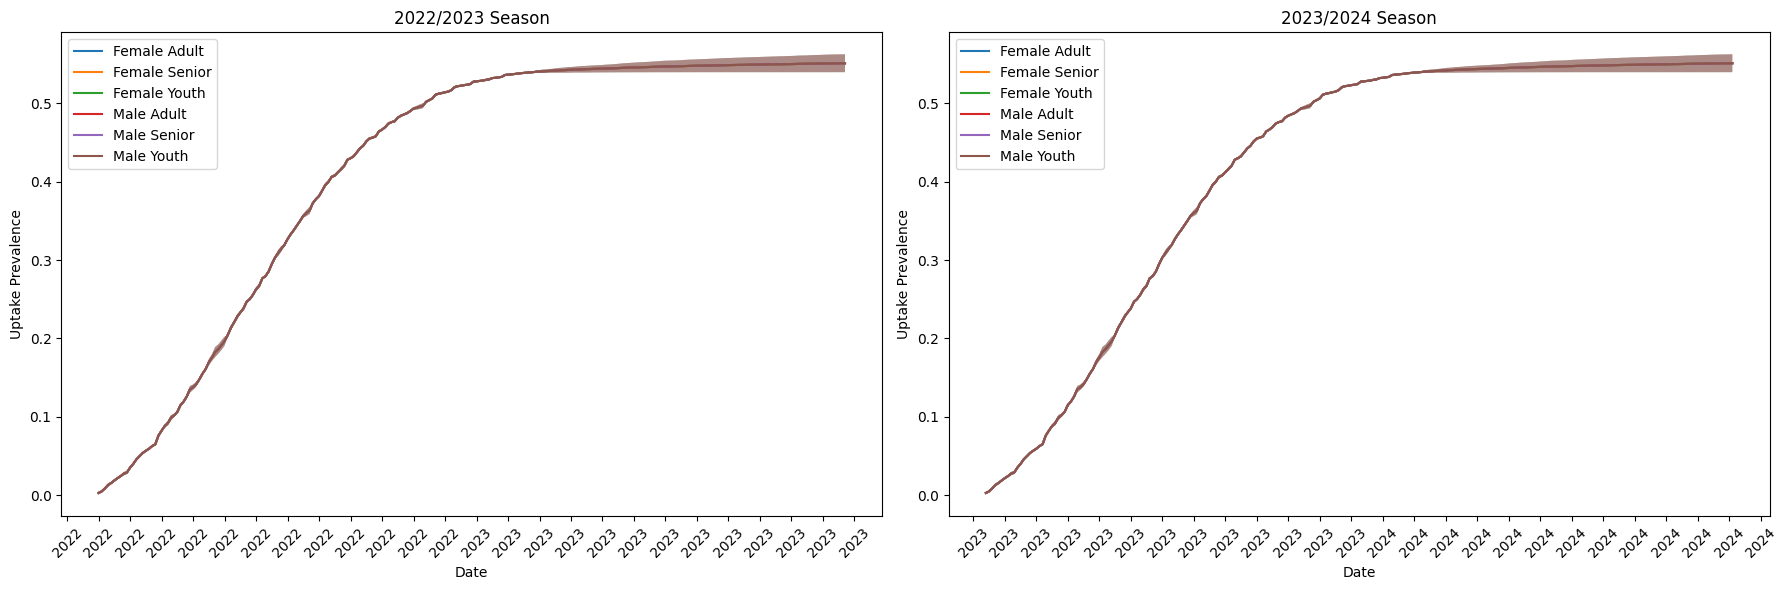

In [ ]:
fig, axes = plt.subplots(
    figsize=(18, 6),
    nrows=1,
    ncols=2,
)

season_axes_map = {
    "2022/2023": axes[0],
    "2023/2024": axes[1],
}

for season, ax in season_axes_map.items():
    ax.set_title(f"{season} Season")
    ax.set_xlabel("Date")
    ax.set_ylabel("Uptake Prevalence")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.tick_params(axis="x", labelrotation=45)

for row in season_and_covariates_df.itertuples():
    ax = season_axes_map[row.season]
    subset_summary_posterior_df = summary_posterior_df[
        (summary_posterior_df["season"] == row.season)
        & (summary_posterior_df["sex"] == row.sex)
        & (summary_posterior_df["age"] == row.age)
    ]
    ax.plot(
        subset_summary_posterior_df["date"],
        subset_summary_posterior_df["mean"],
        label=f"{row.sex.title()} {row.age.title()}",
    )
    ax.fill_between(
        subset_summary_posterior_df["date"],
        subset_summary_posterior_df["lower"],
        subset_summary_posterior_df["upper"],
        alpha=0.2,
    )

for ax in season_axes_map.values():
    ax.legend()

fig.tight_layout()
plt.show()